# **Importação das bibliotecas**

In [1]:
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import mean_squared_error
from scipy.signal import convolve
from scipy.special import wofz
from scipy.special import voigt_profile
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# **Inicialização dos Dados**

É importante, antes, confirmar se as colunas da tabela de dados estão separadas por espaços ou pelo caractere de tabulação *(Tab)*, e também se as casas decimais são separadas por vírgula ou ponto.

## Pressão e Corrente

In [2]:
Pressao = 4.5
Corrente = 100

## O Arquivo de Dados está em Comprimento de Onda ou Número de Onda?

In [3]:
Comp_de_Onda = True #True para Comprimento de Onda || False para Número de Onda

## Inicializar a tabela Razão x Temperatura Eletrônica

In [4]:
arquivo = "RxTe.dat" #Tabela com os dados digitalizados da Tabela R x Te
dados_digitalizados = pd.read_csv(arquivo, delimiter=" ", decimal=",", header=None) #Ajustar conforme o arquivo

#" " -> Espaço || "\t" -> Tab
#"," -> Virgula || "." -> Ponto

## Inicializar os Dados Experimentais de um Espectro

In [5]:
arquivo = f"{Corrente}mA.txt"  #Tabela com dados experimentais do espectro

if Comp_de_Onda:
  dados_experimento = pd.read_csv(arquivo, delimiter="\t", decimal=",", header=None, names=["Comprimento_de_Onda", "Intensidade"]) #Ajustar conforme o arquivo
else:
  dados_experimento = pd.read_csv(arquivo, delimiter=" ", decimal=".", header=None, names=["Numero_de_Onda", "Intensidade"]) #Ajustar conforme o arquivo

#" " -> Espaço || "\t" -> Tab
#"," -> Virgula || "." -> Ponto

## Gráfico do Espectro Experimental

### Espectro Inteiro

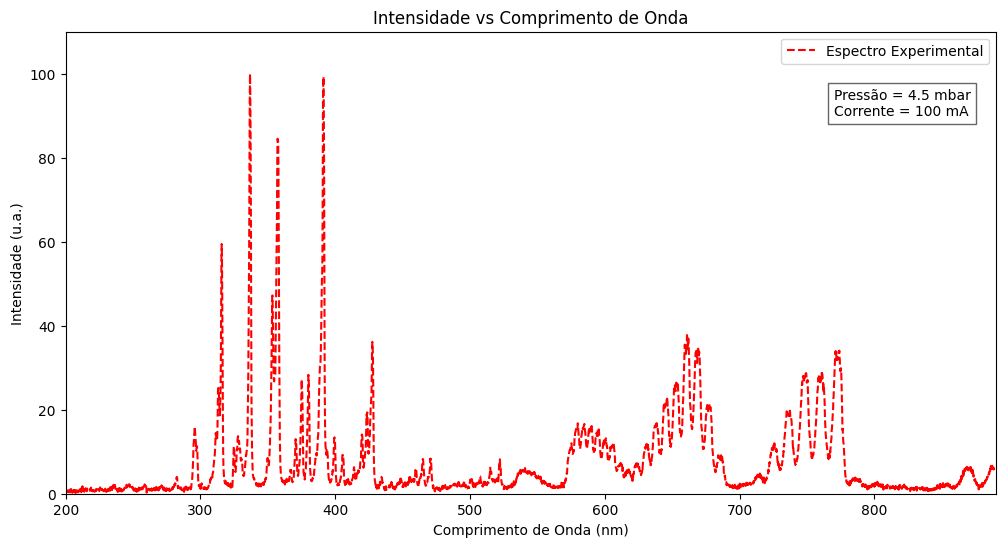

In [6]:
#Separar colunas (1ª: comprimento de onda em nm, 2ª: intensidade)
if Comp_de_Onda:
  x2 = dados_experimento.iloc[:, 0].values  #Primeira coluna (Comprimento de Onda)
else:
  x2 =  1e+7 / dados_experimento.iloc[:, 0].astype(float).values  #Primeira coluna (Numero de Onda)
y2 = dados_experimento.iloc[:, 1].values  #Segunda coluna

#Normalizar Espectro Experimental para intensidade máxima = 100
y2 = (y2 / np.max(y2)) * 100

#######################################################################

#Plotagem do espectro
plt.figure(figsize=(12, 6))
plt.plot(x2, y2, label='Espectro Experimental', color='r', linestyle='--')

#Nome dos eixos
if Comp_de_Onda:
  plt.xlabel('Comprimento de Onda (nm)')
else:
  plt.xlabel('Comprimento de Onda (nm)')
plt.ylabel('Intensidade (u.a.)')

#Ajustes para cada tipo de dado
if Comp_de_Onda:
  plt.title('Intensidade vs Comprimento de Onda')
else:
  plt.title('Intensidade vs Número de Onda de Onda')

#Limita o gráfico nesta região
plt.xlim(200, 890)
plt.ylim(0, 110)
plt.legend()

#Dados ajustados ou calculados
valores = (
    f"Pressão = {Pressao:.1f} mbar\n"
    f"Corrente = {Corrente} mA"
)

#Legenda mostrando os dados da variável "valores"
plt.text(770, max(y2) * 0.900, valores, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.show()

### Espectro Recortado

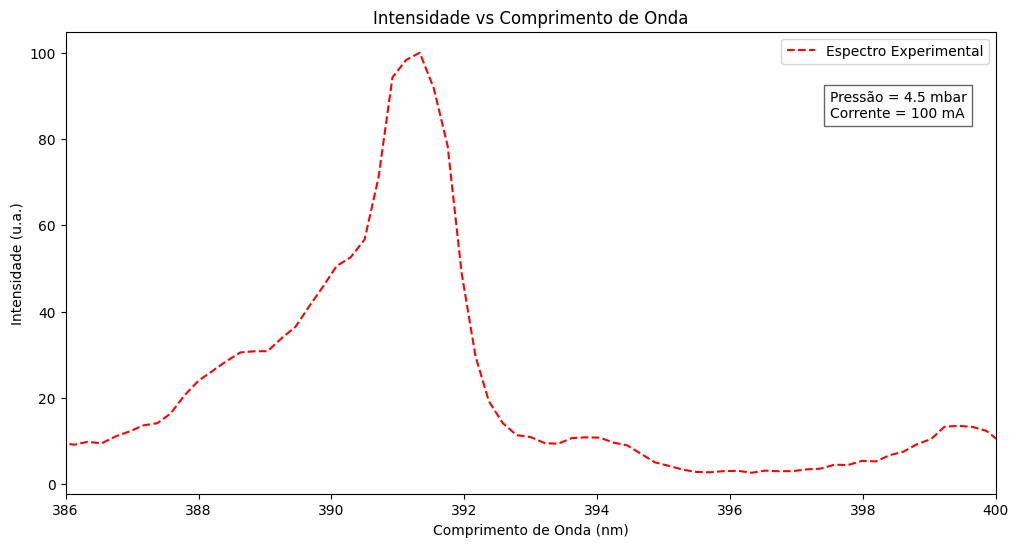

In [7]:
#Separar colunas (1ª: comprimento de onda em nm, 2ª: intensidade)
if Comp_de_Onda:
  x2 = dados_experimento.iloc[:, 0].values  #Primeira coluna (Comprimento de Onda)
else:
  x2 =  1e+7 / dados_experimento.iloc[:, 0].astype(float).values  #Primeira coluna (Numero de Onda)
y2 = dados_experimento.iloc[:, 1].values  #Segunda coluna

#Filtrar dados do Espectro Experimental para o intervalo de 385 nm a 401 nm
mask2 = (x2 >= 385) & (x2 <= 401)
x2 = (x2[mask2] + 0) #Soma para calibrar, caso o eixo x estiver descalibrado
y2 = y2[mask2]

#Normalizar Espectro Experimental para intensidade máxima = 100
y2 = (y2 / np.max(y2)) * 100

#######################################################################

#Plotagem do espectro
plt.figure(figsize=(12, 6))
plt.plot(x2, y2, label='Espectro Experimental', color='r', linestyle='--')

#Nome dos eixos
if Comp_de_Onda:
  plt.xlabel('Comprimento de Onda (nm)')
else:
  plt.xlabel('Comprimento de Onda (nm)')
plt.ylabel('Intensidade (u.a.)')

#Ajustes para cada tipo de dado
if Comp_de_Onda:
  plt.title('Intensidade vs Comprimento de Onda')
else:
  plt.title('Intensidade vs Comprimento de Onda')

#Limita o gráfico nesta região
plt.xlim(386, 400)
plt.legend()

#Dados ajustados ou calculados
valores = (
    f"Pressão = {Pressao:.1f} mbar\n"
    f"Corrente = {Corrente} mA"
)

#Legenda mostrando os dados da variável "valores"
plt.text(397.5, max(y2) * 0.850, valores, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.show()

# **Algoritmo para a Estimativa da Temperatura Eletrônica**

Método descrito no livro de [André Ricard](https://books.google.com.br/books/about/Reactive_Plasmas.html?id=fpfsSAAACAAJ&redir_esc=y) e aplicado por [N. Britun](https://iopscience.iop.org/article/10.1088/0022-3727/40/4/016), que utiliza a razão das intensidades da banda $0-0$ do *Primeiro Sistema Negativo* do $N_2^+$, localizada em $391.44$ $nm$, com a da banda $2-5$ do *Segundo Sistema Positivo* do $N_2$, localizada em $394.30$ $nm$. Esta Razão é escrita como

*   $R = \frac{I (391.44 \hspace{1mm} nm)}{I (393.40 \hspace{1mm} nm)}$.

Como uma das suposições fundamentais seja que o plasma obedeça uma distribuição Maxwelliana, este método foi utilizado como uma *primeira aproximação* para a Temperatura Eletrônica do *glow* negativo do Catodo Oco, que ocorre num regime **fortemente não-Maxwelliano**.

## Interpolação dos Dados Digitalizados

Utilizamos a ferramenta [WebPlot Digitizer](https://automeris.io/) para digitalizar o gráfico da Razão em função da Temperatura Eletrônica presente no livro de [André Ricard](https://books.google.com.br/books/about/Reactive_Plasmas.html?id=fpfsSAAACAAJ&redir_esc=y). Com isso, aplicamos o código abaixo para:

*   Trabalhar com a Temperatura Eletrônica em função da Razão;
*   Gerar uma interpolação (cúbica) para coletar os dados que não foram digitalizados;
*   Gerar um gráfico comparando os dados digitalizados com a interpolação.

Assim, teremos uma função chamada *Temperatura_Eletronica* que receberá um valor de Razão e retornará uma estimativa da Temperatura Eletrônica.

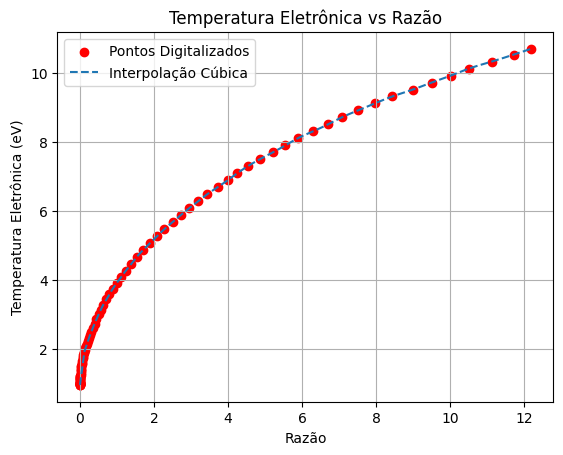

In [8]:
#Faremos um gráfico com TE em função de R
R = dados_digitalizados.iloc[:, 1].values  #Razão || Segunda Coluna
TE = dados_digitalizados.iloc[:, 0].values  #Temperatura Eletrônica || Primeira Coluna

#Função de interpolação cúbica
Temperatura_Eletronica = interp1d(R, TE, kind='cubic')

#Gerar pontos para plotar a interpolação
R_intermediario = np.linspace(min(R), max(R), 100)
TE_intermediario = Temperatura_Eletronica(R_intermediario)

#Gráfico original (Digitalizado)
plt.scatter(R, TE, color='red', label='Pontos Digitalizados')

#Curva interpolada
plt.plot(R_intermediario, TE_intermediario, label='Interpolação Cúbica', linestyle='--')

plt.legend()
plt.xlabel("Razão")
plt.ylabel("Temperatura Eletrônica (eV)")
plt.title("Temperatura Eletrônica vs Razão")
plt.grid()
plt.show()

## Ajuste Potencial para ser utilizado como estimativa para Razões superiores a $12.1720$

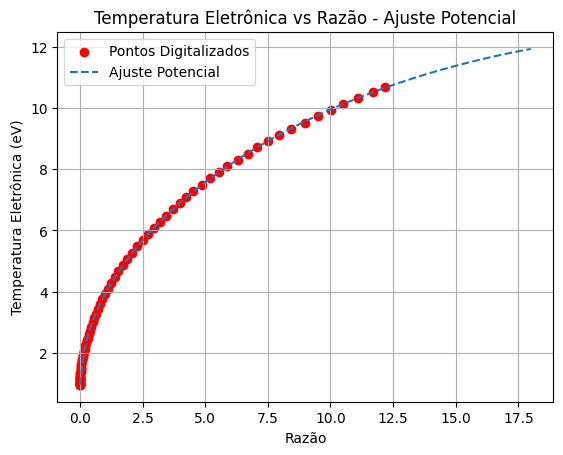

In [9]:
def Ajuste_Potencial(x, a, b, c, d, e):
    return a * (x ** b) + c + d * x + e * (x ** 2)

parametros, _ = curve_fit(Ajuste_Potencial, R, TE, p0=[1, 0.5, 1, 0.1, 0.01], maxfev=10000)

#Gerar pontos para plotar o ajuste
R_intermediario = np.linspace(min(R), 18, 100)
TE_ajustado = Ajuste_Potencial(R_intermediario, *parametros)

#Gráfico original (Digitalizado)
plt.scatter(R, TE, color='red', label='Pontos Digitalizados')

#Curva ajustada
plt.plot(R_intermediario, TE_ajustado, label='Ajuste Potencial', linestyle='--')

plt.legend()
plt.xlabel("Razão")
plt.ylabel("Temperatura Eletrônica (eV)")
plt.title("Temperatura Eletrônica vs Razão - Ajuste Potencial")
plt.grid()
plt.show()

## Cálculo da Incerteza Associada à Temperatura Eletrônica

Utilizamos o primeiro conjunto de valores $(Te, R)$ presente no gráfico original como os valores exatos. Com isso, aplicamos $R$ na função interpolada para estimar uma incerteza associada à interpolação.

In [10]:
R_exato = 0.001  #Valor exato da Razão
TE_exato = 1  #Valor exato da Temperatura Eletrônica

#Interpolation Calculation
TE_ajustado = Ajuste_Potencial(R_exato, *parametros)
TE_interpolado = Temperatura_Eletronica(R_exato)

#Uncertainty Calculation
erro_ajustado = abs(TE_exato - TE_ajustado)
erro_interpolado = 2 * abs(TE_exato - TE_interpolado)

print(f"Temperatura Eletrônica Real: {TE_exato} eV")
print(f"Temperatura Eletrônica Estimada: {TE_ajustado:.4f} eV")
print(f"Temperatura Eletrônica Estimada: {TE_interpolado:.4f} eV")
print(f"Erro do ajuste estimado: {erro_ajustado:.4f} eV")
print(f"Erro da interpolação estimado: {erro_interpolado:.4f} eV")

Temperatura Eletrônica Real: 1 eV
Temperatura Eletrônica Estimada: 0.9672 eV
Temperatura Eletrônica Estimada: 0.9687 eV
Erro do ajuste estimado: 0.0328 eV
Erro da interpolação estimado: 0.0626 eV


## Cálculo da Razão Real de um Espectro Experimental

Neste bloco, lemos um espectro experimental cujos dados estão dispostos em pares $(\mbox{Comprimento de onda}, \mbox{Intensidade})$ para o cálculo da Razão real entre as intensidades. Importante notar que, como o espectro real possui baixa resolução, os comprimentos de onda não são exatamente aqueles previstos, mas possuem uma ligeira discrepância.

In [11]:
if Comp_de_Onda:
  #Comprimentos de Onda que estudaremos
  V1 = 391.33
  V2 = 394.25

  #Atribuição das intensidades (Utilizando Lista)
  I1 = dados_experimento.loc[dados_experimento["Comprimento_de_Onda"] == V1, "Intensidade"].values
  I2 = dados_experimento.loc[dados_experimento["Comprimento_de_Onda"] == V2, "Intensidade"].values
else:
  #Numeros de Onda que estudaremos
  V1 = 25540.13597 #cm-1
  V2 = 25361.85904 #cm-1

  #Atribuição das intensidades (Utilizando Lista)
  I1 = dados_experimento.loc[dados_experimento["Numero_de_Onda"] == V1, "Intensidade"].values
  I2 = dados_experimento.loc[dados_experimento["Numero_de_Onda"] == V2, "Intensidade"].values

#Verificar se encontramos corretamente os valores
if I1.size > 0 and I2.size > 0:
    I1 = I1[0]
    I2 = I2[0]

    Razao = I1 / I2 if I2 != 0 else float("nan")  #Isso evita divisão por zero

    if Comp_de_Onda:
      print(f"Intensidade em {V1} nm: {I1}")
      print(f"Intensidade em {V2} nm: {I2}")
    else:
      print(f"Intensidade em {V1} cm-1: {I1}")
      print(f"Intensidade em {V2} cm-1: {I2}")

    print(f"Razão: {Razao:.4f}")
else:
    print("Erro: Um ou ambos valores não foram encontrados na tabela.")

Intensidade em 391.33 nm: 20799.17
Intensidade em 394.25 nm: 1998.82
Razão: 10.4057


## Estimativa da Temperatura Eletrônica, em *Kelvin*

Aqui aplicamos a interpolação para estimar a Temperatura Eletrônica do experimento. Importante observar que o valor calculado está em $eV$, unidade usual em Física Molecular. Porém, para o método comparativo, precisamos convertê-la em *Kelvin*, utilizando a aproximação

*   $1eV ≈ 11604 K$.

In [12]:
if Razao <= 12.172033905486556:
  Te_eV = Temperatura_Eletronica(Razao)
else:
  Te_eV = Ajuste_Potencial(Razao, *parametros)

Te = Te_eV * 11604 #1eV é aproximadamente 11604K

print(f"Temperatura Eletrônica em eV: {Te_eV:.4f} eV")
print(f"Temperatura Eletrônica em Kelvins: {Te:.4f} K")

Temperatura Eletrônica em eV: 10.0852 eV
Temperatura Eletrônica em Kelvins: 117028.5207 K


# **Parâmetros e Constantes**

Aqui colocamos os parâmetros de interesse, como as temperaturas, as constantes fundamentais e as constantes espectroscópicas necessárias para os cálculos.

## Temperaturas

As três temperaturas estão em *Kelvin (K)*. Como apontado em [N. Britun](https://iopscience.iop.org/article/10.1088/0022-3727/40/4/016), devemos prever a desigualdade

*   $T_{el} > T_v > T_r$,

que é um resultado clássico da Física Molecular.

In [13]:
TEMP_ELE = Te #Temperatura Eletrônica
TEMP_V = 3700 #Temperatura Vibracional | Ajuste Manual
TEMP_R = 600 #Temperatura Rotacional | Ajuste Manual

## Parâmetros Moleculares

Alguns parâmetros para os cálculos das intensidades. Aqui colocamos uma estimativa para o $\alpha$, que descreve o perfil do espectro sintético juntamente com a Temperatura Vibracional e Rotacional. Também, colocamos valores iguais e arbitrários para as concentrações de $N_2$ e $N_2^+$, visto que as intensidades serão normalizadas posteriormente e que $\alpha$ já inclui a razão $[N_2^+] / [N_2]$.

In [14]:
alpha = 0.45 #Ajuste Manual

C_N2 = 1 #Como a intensidade é normalizada, posso utilizar um valor arbitrário
C_N2_Mais = 1 #1 para evitar propagação de incertezas. Quem vai definir a razão é o alpha

## Constantes Fundamentais

As constantes estão na unidade de medida CGS (centímetro, grama, segundos).

In [15]:
h = 6.626176e-27 # Constante de Planck  || erg.s
c = 29_979_245_800 # Velocidade da Luz || cm/s
k = 1.380649e-16 # Constante de Boltzmann || erg/K

## Constantes Espectroscópicas do $N_2$: Segundo Sistema Positivo $C^3\Pi_u^+ → B^3\Pi_g^+ $

Subescrito $1$ simboliza o estado superior $'$, e o subescrito $2$ indica o estado inferior $''$. As constantes foram retiradas do livro de [Herzberg](https://www.google.com.br/books/edition/Spectra_of_Diatomic_Molecules/UdwNAQAAIAAJ?hl=pt-BR&gbpv=0&bsq=inauthor:%22Gerhard%20Herzberg%22).

### Estado Superior $C^3\Pi_u^+$

In [16]:
t1 = 89147.3 #Termo Eletrônico

#Constantes Vibracionais
we1 = 2035.1
wexe1 = 17.08
weye1 = -2.15
weze1 = 0 #Sem dados

#Constantes Rotacionais de Equilíbrio
be_1 = 1.8259
ae_1 = 0.0197

### Estado Inferior $ B^3\Pi_g^+ $

In [17]:
t2 = 59626.3 #Termo Eletrônico

#Constantes Vibracionais
we2 = 1734.11
wexe2 = 14.47
weye2 = 0 #Sem dados
weze2 = 0 #Sem dados

#Constantes Rotacionais de Equilíbrio
be_2 = 1.6380
ae_2 = 0.0184

### Dicionário com os Parâmetros Constantes para a Transição $C^3\Pi_u^+ → B^3\Pi_g^+ $

SSP: Segundo Sistema Positivo

In [18]:
Quantidades_SSP = {
    # Termos Eletrônicos
    't1': t1,  # Termo Eletrônico Superior
    't2': t2,  # Termo Eletrônico Inferior

    # Temperaturas
    'Tv': TEMP_V,
    'Tr': TEMP_R,

    # Constantes Vibracionais
    'we1': we1, 'wexe1': wexe1, 'weye1': weye1, 'weze1': weze1,
    'we2': we2, 'wexe2': wexe2, 'weye2': weye2, 'weze2': weze2,

    # Constantes Rotacionais
    'be_1': be_1, 'ae_1': ae_1, 'be_2': be_2, 'ae_2': ae_2,

    # Outros Valores
    'Concentracao': C_N2,
    'h': h,  # Constante de Planck
    'c': c,  # Velocidade da Luz
    'En': h * c * t1,  # Energia Eletrônica
    'Lambda': 1,  # Lambda = 1 para o N2
    'Alpha': alpha,
    'kTel': k * TEMP_ELE
}

# Função para calcular kTv e kTr dinamicamente
def atualizar_k(Quantidades):
    Quantidades['kTv'] = k * Quantidades['Tv']
    Quantidades['kTr'] = k * Quantidades['Tr']

# Inicializa os valores de kTv, kTr e kTel
atualizar_k(Quantidades_SSP)

## Constantes Espectroscópicas do $N_2^+$: Primeiro Sistema Negativo $B^2\Sigma _u^+ → X^2\Sigma _g ^+$

Subescrito $1$ simboliza o estado superior $'$, e o subescrito $2$ indica o estado inferior $''$. As constantes foram retiradas do livro de [Herzberg](https://www.google.com.br/books/edition/Spectra_of_Diatomic_Molecules/UdwNAQAAIAAJ?hl=pt-BR&gbpv=0&bsq=inauthor:%22Gerhard%20Herzberg%22). Os Termos Eletrônicos escreveremos como $T_n$ quando citá-los, assim como feito por [H. Nassar](https://iopscience.iop.org/article/10.1088/0022-3727/37/14/005).

### Estado Superior $B^2\Sigma _u^+$

In [19]:
t1 = 25461.5

#Constantes Vibracionais
we1 = 2419.84
wexe1 = 23.19
weye1 = -0.5375
weze1 = 0 #Sem dados

#Constantes Rotacionais de Equilíbrio
be_1 = 2.083
ae_1 = 0.0195

### Estado Inferior $X^2\Sigma _g ^+$

In [20]:
t2 = 0 #Termo Eletrônico

#Constantes Vibracionais
we2 = 2207.19
wexe2 = 16.136
weye2 = -0.04
weze2 = 0 #Sem dados

#Constantes Rotacionais de Equilíbrio
be_2 = 1.932
ae_2 = 0.020

### Dicionário com os Parâmetros Constantes para a Transição $B^2\Sigma _u^+ → X^2\Sigma _g ^+$

PSN: Primeiro Sistema Negativo

In [21]:
Quantidades_PSN = {
    # Termos Eletrônicos
    't1': t1,  # Termo Eletrônico Superior
    't2': t2,  # Termo Eletrônico Inferior

    # Temperaturas
    'Tv': TEMP_V,
    'Tr': TEMP_R,

    # Constantes Vibracionais
    'we1': we1, 'wexe1': wexe1, 'weye1': weye1, 'weze1': weze1,
    'we2': we2, 'wexe2': wexe2, 'weye2': weye2, 'weze2': weze2,

    # Constantes Rotacionais
    'be_1': be_1, 'ae_1': ae_1, 'be_2': be_2, 'ae_2': ae_2,

    # Outros Valores
    'Concentracao': C_N2_Mais,
    'h': h,  # Constante de Planck
    'c': c,  # Velocidade da Luz
    'En': h * c * t1,  # Energia Eletrônica
    'Lambda': 0,  # Lambda = 0 para o N2+
    'Alpha': alpha,
    'kTel': k * TEMP_ELE
}

# Função para calcular kTv e kTr dinamicamente
def atualizar_k(Quantidades):
    Quantidades['kTv'] = k * Quantidades['Tv']
    Quantidades['kTr'] = k * Quantidades['Tr']

# Inicializa os valores de kTv, kTr e kTel
atualizar_k(Quantidades_PSN)

# **Funções para os Cálculos Numéricos**

Esse grupo de células servirá para escrevermos todas as funções que serão utilizadas durante a execução do código

**Observação:** Lambda $(\Lambda)$ representa o momento angular dos elétrons, desconsiderando o spin, sobre o eixo internuclear da molécula. Para transições $\Sigma → \Sigma$, como no caso do Primeiro Sistema Negativo do $N_2^+$, $\Lambda = 0$. Já para transições $\Pi → \Pi$, como no caso do Segundo Sistema Positivo do $N_2$, $\Lambda = 1$.

## Parâmetros para os Termos Rotacionais

Considerando a molécula rotacionando e vibrando ao mesmo tempo, devemos considerar os termos rotacionais dependendo da vibração. Por isso, a necessidade de utilizarmos o *número quântico vibracional* $v$. Em ordem, os parâmetros são dados por

*   $B_v = B_e - \alpha_e \left(v+\frac{1}{2}\right) + \dots$, que é um valor médio da constante $B$ quando a vibração é considerada. Já $B_e$ representa o recíproco do momento de inércia multiplicado por um fator,

*   $D_e = \frac{4B_e^3}{\omega_e^2}$, faz com que as linhas rotacionais se aproximem,

*   $\beta_e = D_e \left(\frac{8\omega_ex_e}{\omega_e} - \frac{5 \alpha_e}{B_e} - \frac{\alpha_e^2\omega_e}{24B_e^3} \right)$, é uma constante de ajuste

*   $D_v = D_e + \beta_e \left(v+\frac{1}{2}\right) + \dots$, representa a influência da Força Centrífuga,

*   $Y = \frac{A}{B_v}$, que mede a força do acoplamento do spin com o eixo internuclear,

*   $Z_1 = \Lambda ^2 Y (Y - 4) + \frac{4}{3} + 4J(J+1)$, usada nos termos de Budo (N2),

*   $Z_2 = \frac{1}{3 Z_1} [\Lambda ^2 Y (Y - 1) - \frac{4}{9} - 2J(J+1)]$, Usada nos termos de Budo (N2).

In [22]:
def Bv(Be, ae, v): #Bv é um valor médio da constante B quando a vibração é considerada
  return (Be - ae * (v + 0.5)) #Be representa o recíproco do momento de inércia multiplicado por um fator

def De(Be, we): #De faz com que as linhas rotacionais se aproximem
  return ((4 * (Be ** 3)) / (we ** 2))

def beta_e(ae, wexe, Be, we): #Uma constante de ajuste
  return (De(Be, we) * ( ((8 * wexe) / (we)) - ((5 * ae) / (Be)) - (((ae ** 2) * we) / (24 * (Be ** 3))) ))

def Dv(ae, wexe, Be, we, v): #Representa a influência da Força Centrífuga
  return (De(Be, we) + beta_e(ae, wexe, Be, we) * (v + 0.5))

def Y(A, Be, ae, v): #Mede a força do Acoplamento do Spin com o eixo internuclear
  return (A / Bv(Be, ae, v))

def Z1(J, A, Be, ae, v, Lambda): #Usada nos termos de Budo (N2)
  return ((Lambda ** 2) * Y(A, Be, ae, v) * (Y(A, Be, ae, v) - 4) + 4.0/3.0 + 4 * J * (J + 1))

def Z2(J, A, Be, ae, v, Lambda): #Usada nos termos de Budo (N2)
  return ((1/(3*Z1(J, A, Be, ae, v, Lambda))) * ((Lambda ** 2) * Y(A, Be, ae, v) * (Y(A, Be, ae, v) - 1) - 4.0/9.0 - 2 * J * (J + 1)))

## Termos Rotacionais de Budó para o $N_2$ (Tripleto)

A variável *termo* indica cada linha do tripleto. Esses termos são referentes ao desacoplamento do spin para o caso intermediário entre os casos (a) e (b) de Hund, obtidos por [A. Budó](https://doi.org/10.1007/BF01341523). Os Termos são

*   $F_1(J) = B_v[J(J+1) - \sqrt{Z_1} - 2 Z_2] - D_v(J - \frac{1}{2}) ^4$,

*   $F_2(J) = B_v[J(J+1) + 4 Z_2] - D_v(J + \frac{1}{2}) ^4 $,

*   $F_3(J) = B_v[J(J+1) + \sqrt{Z_1} - 2 Z_2] - D_v(J + \frac{3}{2}) ^4$.

In [23]:
def termoRotacional_Budo(J, A, Be, ae, v, Lambda, we, wexe, termo):
  if termo == 1:
    return Bv(Be, ae, v) * (J * (J + 1) - mt.sqrt(Z1(J, A, Be, ae, v, Lambda)) - 2 * Z2(J, A, Be, ae, v, Lambda)) - Dv(ae, wexe, Be, we, v) * ((J - 0.5) ** 4)

  if termo == 2:
    return Bv(Be, ae, v) * (J * (J + 1) + 4 * Z2(J, A, Be, ae, v, Lambda)) - Dv(ae, wexe, Be, we, v) * ((J + 0.5) ** 4)

  if termo == 3:
    return Bv(Be, ae, v) * (J * (J + 1) + mt.sqrt(Z1(J, A, Be, ae, v, Lambda)) - 2 * Z2(J, A, Be, ae, v, Lambda)) - Dv(ae, wexe, Be, we, v) * ((J + 3.0/2.0) ** 4)


## Termos Rotacionais de Mulliken para o $N_2^+$ (Dubleto)

A variável *termo* indica cada linha do dubleto. Esses Termos são referentes ao *caso (b) de Hund*, presentes em [Mulliken](https://doi.org/10.1103/RevModPhys.2.60), e são dados por

*   $F_1(K) = B_v K(K+1) + \frac{1}{2} \gamma K - D_vK^2(K + 1)^2$,

*   $F_2(K) = B_v K(K+1) - \frac{1}{2} \gamma (K + 1) - D_vK^2(K + 1)^2$,

Aqui, **K** representa o *momento angular total, desconsiderando o spin* e **J** representa o *momento angular total, incluindo o spin*. $F_1(K)$ refere-se aos componentes com $J = K + \frac{1}{2}$ e $F_2(K)$ refere-se àqueles com $J = K - \frac{1}{2}$. A constante de separação $\gamma$ é pequena em relação à $B_v$.


In [24]:
def termoRotacional_Mulliken(K, Be, ae, v, gamma, we, wexe, termo): #Para o N2+, termos dupleto
  if termo == 1:
    return Bv(Be, ae, v) * (K) * (K + 1) + (0.5 * gamma) * (K) - Dv(ae, wexe, Be, we, v) * ((K) ** 2) * ((K + 1) ** 2)

  if termo == 2:
    return Bv(Be, ae, v) * (K) * (K + 1) - (0.5 * gamma) * (K + 1) - Dv(ae, wexe, Be, we, v) * ((K) ** 2) * ((K + 1) ** 2)


## Termo Vibracional (Vibrating Rotator)

Implementamos até $\omega_e z_e$, embora não tenhamos encontrado dados o suficiente para incluir esta constante no programa. O Termo Vibracional é expresso por

*   $G(v) = (v + \frac{1}{2})\omega_e - (v + \frac{1}{2})^2 ω_e x_e + (v + \frac{1}{2})^3 \omega_e y_e - (v + \frac{1}{2})^4 \omega_e y_e + \dots$.

In [25]:
def termoVibracional(v, we, wexe, weye, weze):
    return ((v + 0.5) * we) - (((v + 0.5) ** 2) * wexe) + (((v + 0.5) ** 3) * weye) - (((v + 0.5) ** 4) * weze)

## Fatores de Hönl-London

Temos fatores diferentes para o $N_2$ e para o $N_2^+$.

### Fatores para o $N_2$

Esses são os fatores genéricos listado em [Herzberg](https://www.google.com.br/books/edition/Spectra_of_Diatomic_Molecules/UdwNAQAAIAAJ?hl=pt-BR&gbpv=0&bsq=inauthor:%22Gerhard%20Herzberg%22) para $\Delta \Lambda = 0$ (isto é, ambos os níveis eletrônicos com o mesmo valor de $\Lambda$). As fórmulas são

*   $S_J^R = \frac{(J' + \Lambda)(J' - \Lambda)}{J'}$,

*   $S_J^Q = \frac{(2J' + 1) \Lambda^2}{J' (J' + 1)}$,

*   $S_J^P = \frac{(J' + 1 + \Lambda)(J' + 1 - \Lambda)}{J' + 1}$.

In [26]:
def SJ_R(J, Lambda): #Para a Rama R
    return ((J + Lambda) * (J - Lambda)) / J

def SJ_Q(J, Lambda): #Para a Rama Q
    return ((2 * J + 1) * (Lambda ** 2)) / (J * (J + 1))

def SJ_P(J, Lambda): #Para a Rama P
    return ((J + 1 + Lambda) * (J + 1 - Lambda)) / (J + 1)

### Fatores para o $N_2^+$

Esses são os fatores específicos para transições $^2\Sigma$ $→$  $^2\Sigma$, encontrados no livro de [Herzberg](https://www.google.com.br/books/edition/Spectra_of_Diatomic_Molecules/UdwNAQAAIAAJ?hl=pt-BR&gbpv=0&bsq=inauthor:%22Gerhard%20Herzberg%22), que são dados por

*   $S_J^R = \frac{(J'' + 1) ^2 - \frac{1}{4}}{J'' + 1}$,

*   $S_J^Q = \frac{2J'' + 1}{4 J'' (J'' + 1)}$,

*   $S_J^P = \frac{J'' ^2 - \frac{1}{4}}{J''}$.

In [27]:
def SJ_R_N2_Mais(J, Lambda): #Para a Rama R
  return ((((J + 1) ** 2) - 1.0/4.0) / (J + 1))

def SJ_Q_N2_Mais(J, Lambda): #Para a Rama Q
  return ((2 * J + 1) / (4 * J * (J + 1)))

def SJ_P_N2_Mais(J, Lambda): #Para a Rama P
  return ((J ** 2 - 1.0/4.0) / J)

## Cálculo das Funções de Partição

Aqui definimos as Funções de Partição Eletrônica, Vibracional e Rotacional, juntamente com o termo $G_0(v)$ utilizado no cálculo da Função de Partição Vibracional. A Eletrônica foi retirada do livro de [M. Capitelli](https://ui.adsabs.harvard.edu/abs/2005ESAST.246.....C/abstract), enquanto a Vibracional e a Rotacional de [Herzberg](https://www.google.com.br/books/edition/Spectra_of_Diatomic_Molecules/UdwNAQAAIAAJ?hl=pt-BR&gbpv=0&bsq=inauthor:%22Gerhard%20Herzberg%22). O termo $G_0(v)$ é

*   $G_0(v) = \omega_0 v - \omega_0 x_0 v^2 + \omega_0 y_0 v^3 + \cdots$,

em que as constantes são

*   $\omega_0 = \omega_e - \omega_e x_e + \frac{3}{4} \omega_e y_e + \cdots$,

*   $\omega_0 x_0 = \omega_e x_e - \frac{3}{2} \omega_e y_e + \cdots$,

*   $\omega_0 y_0 = \omega_e y_e + \dots$.

Já as Funções de Partição são dadas por

*   $Q_{el} = {\frac{1}{\sigma}} \sum_n ^{n_{max}} g_n e^{- E_{el}(n) / kT_{el}}$,

*   $Q_v = 1 + e ^{-G_0(1) hc / kT_v} + e ^{-G_0(2) hc / kT_v} + \dots$,

*   $Q_r = \sum_J ^{J_{max}} (2J + 1) e^{- BJ(J + 1) hc / kT_r}$,

onde $\sigma = 2$ para moléculas homonucleares e $g_n$ é o peso estatístico. A Função de Partição Rotacional segue o modelo do Rotor Rígido. Para a implementação da Função de Partição Eletrônica do $N_2^+$, consideramos os três primeiros estados eletrônicos, em ordem decrescente de energia: $B^2\Sigma_u^+$, $A^2\Pi_u$ e $X^2\Sigma_g ^+$ (estado fundamental). Os Termos Eletrônicos de $B^2\Sigma_u^+$ e $X^2\Sigma_g ^+$ (igual a zero) foram retirados de [Herzberg](https://www.google.com.br/books/edition/Spectra_of_Diatomic_Molecules/UdwNAQAAIAAJ?hl=pt-BR&gbpv=0&bsq=inauthor:%22Gerhard%20Herzberg%22), enquanto o termo eletrônico de $A^2\Pi_u$ foi retirado de [K. P. Hube](https://link.springer.com/book/10.1007/978-1-4757-0961-2).

### **Peso Estatístico**

Os valores dos pesos estatísticos podem ser derivado através da teoria exposta em [D. S. Villars](https://pubs.acs.org/doi/10.1021/cr60040a003), o qual afirma que o peso estatístico é dado por

* $w_{el} = (2S + 1) g_{\Lambda}$,

onde

* $g_\Lambda = 2$ se $\Lambda > 0$, e $g_\Lambda = 1$ se $\Lambda = 0$.

Como $S = 1/2$ para os três estados eletrônicos, $\Lambda = 0$ para estados $\Sigma$ e $\Lambda = 1$ para estados $\Pi$, então o peso estatístico é

* **2** para $B^2\Sigma_u^+$,

* **4** para $A^2\Pi_u$,

* **2** para $X^2\Sigma_g ^+$.

**Observação:** Somente há Função de Partição para o $N_2^+$ pois consideramos que apenas o estado fundamental do $N_2$ está significativamente povoado, conforme sugere a condição (2) do método de André Ricard.

In [28]:
#Termo Vibracional considerando o Termo do nível de v=0 como zero
def G0(v, we, wexe, weye):
    return ((we - wexe + (3.0/4.0) * weye) * v) - ((wexe - (3.0/2.0) * weye) * (v ** 2)) + (weye * (v ** 3))

#Função de Partição Eletrônica para o N2+
def FdeParticaoE_N2_Mais(kTel):
    return (1.0/2.0) * ( (2 * np.exp(- ((25461.5 * h * c) / (kTel)))) + (4 * np.exp(- ((9166.95 * h * c) / (kTel)))) + (2 * np.exp(- ((0 * h * c) / (kTel)))) )

#Função de Partição Vibracional
def FdeParticaoV(we, wexe, weye, h, c, kTv, v_max):
    Qv = 1
    for v in range(v_max):
      if v == 0:
        continue
      Qv += np.exp(- ((G0(v, we, wexe, weye) * h * c) / (kTv)))
    return Qv

#Função de Partição Rotacional
def FdeParticaoR(j_max, B, h, c, kTr): #Considerando como Rotor Rígido
    Qr = 1
    for j in range(j_max):
      if j == 0:
        continue
      Qr += (2*j + 1) * np.exp( - (B * (j*(j + 1)) * h * c) / (kTr))
    return Qr

## Funções para o Cálculo das Intensidades

Definimos os termos $C_{N_2}$ e $C_{N_2^+}$ na mesma função *C_Termo*, em que

*   $C_{N_2} = \frac{8 \pi ^3 c}{9} [N_2] e ^{- (E_{n'} / k T_{el})}$,

*   $C_{N_2^+} = \frac{16 \pi ^3 c}{9} [N_2^+] e ^{- (E_{n'} / k T_{el})}$,

o superescrito $'$ representa o estado superior, $E_{n'} = hcT_n$ ($T_n$ é o Termo Eletrônico, enquanto a Temperatura é escrita por $T_{el}$), $[N_2]$ é a concentração de $N_2$ e $[N_2^+]$ a concentração de $N_2^+$. Com isso, a *Intensidade Absoluta das Linhas Rotacionais* é escrita por

*   $ϵ_{N_2} =  C_{N_2^+} \frac{ \bar{R_e^2} q_{v'v''} e^{-(E_{v'}/kT_v)} S_{J'J''} \sigma^4 e^{-(E_{J'}/kT_r)}}{Q_{N_2}(T_{el}, T_v, T_r)}$,

*   $ϵ_{N_2^+} = C_{N_2^+} \frac{ \bar{R_e^2} q_{v'v''} e^{-(E_{v'}/kT_v)} S_{J'J''} \sigma^4 e^{-(E_{J'}/kT_r)}}{Q_{N_2^+}(T_{el}, T_v, T_r)} 3\phi_{p'}$,

em que $Q_{N_2}$ e $Q_{N_2^+}$ são as Funções de Partição da molécula e do íon, respectivamente. O parâmetro $\phi_{p'}$ é igual a $\frac{1}{3}$ para valores pares de $J'$, e $\frac{2}{3}$ para valores ímpares de $J'$.

A função *Calcular_Intensidade* calcula a intensidade de uma linha rotacional (lembrando que o espectro é composto por linhas Rotacionais correspondentes a diferentes transições Vibracionais e Eletrônicas), aplicando o fator de Hönl-London referente à determinada linha, escolhendo o valor de $\phi$ caso a linha pertencer ao $N_2^+$ e, por fim, multiplica o inverso do fator *Alpha* nas linhas do $N_2$ para aplicar a normalização proposta pelo artigo de [H. Nassar](https://iopscience.iop.org/article/10.1088/0022-3727/37/14/005).

In [29]:
#Esta função representa o C do artigo, que é utilizado na fórmula da intensidade absoluta
def C_Termo(Luz, En1, kTel, Concentracao, Lambda):
    if Lambda == 1: #1 para N2
      return ((8 * (np.pi ** 3) * Luz) / 9.0) * Concentracao * (np.exp(- (En1 / (kTel))))
    if Lambda == 0: #0 para N2+
      return ((16 * (np.pi ** 3) * Luz) / 9.0) * Concentracao * (np.exp(- (En1 / (kTel))))

#Esta função é Intensidade Absoluta das Linhas Rotacionais, como proposta pelo artigo
def Epsilon(C, M_de_Transicao_Eletronica, q, Ev1, kTv, S, Sigma_ul, EJ1, kTr, F_de_Particao, Phi, Lambda):
    if Lambda == 1: #1 para N2
      return C * ((M_de_Transicao_Eletronica * q * (np.exp(- (Ev1 / (kTv)))) * S * (Sigma_ul ** 4) * (np.exp(- (EJ1 / (kTr))))) / F_de_Particao)
    if Lambda == 0: #0 para N2+
      return C * ((M_de_Transicao_Eletronica * q * (np.exp(- (Ev1 / (kTv)))) * S * (Sigma_ul ** 4) * (np.exp(- (EJ1 / (kTr))))) / F_de_Particao) * 3 * Phi

#Esta função recebe os parâmetros e aplica os fatores de Hönl-London para cada Linha, além disso,
#também faz o cálculo do Phi para as linhas do N2+, calcula a intensidade da linha e multiplica
#pelo fator Alpha caso se tratar de linhas do N2.
def Calcular_Intensidade(row, **kwargs):
    #Aplica o Hönl-London referente à linha
    if row['rama'] == 'Q':
      S = row['SQ']
    elif row['rama'] == 'R':
      S = row['SR']
    elif row['rama'] == 'P':
      S = row['SP']
    else: #Caso ocorrer algum erro
      S = 0

    phi = 0

    if kwargs.get('Lambda', -1) == 0: #N2+
      if row['k1'] % 2 == 0:
        phi = 1.0/3.0
      else:
        phi = 2.0/3.0

    #Aqui chamamos a função Epsilon
    intensidade = Epsilon(
      C = kwargs.get('Const', 0),
      M_de_Transicao_Eletronica = kwargs.get('Re2', 0),
      q = kwargs.get('qvv', 0),
      Ev1 = kwargs.get('Ev', 0),
      kTv = kwargs.get('kTv', 0),
      S = S,
      Sigma_ul = row['sigma'],
      EJ1 = (h * c * row['F1']),
      kTr = kwargs.get('kTr', 0),
      F_de_Particao = kwargs.get('Q', 0),
      Phi = phi,
      Lambda = kwargs.get('Lambda', -1)
    )

    #Como diz o artigo de Nassar, as linhas do N2 são normalizadas multiplicando pelo inverso do Alpha.
    if kwargs.get('Lambda', -1) == 0: #0 para N2+
      return intensidade
    if kwargs.get('Lambda', -1) == 1: #0 para N2
      return (intensidade / kwargs.get('Alpha', 0))

## Função para Calcular a Razão $[N_2^+] / [N_2]$

Estimando $Alpha$ baseado em um espectro experimental, sabendo a Temperatura Eletrônica e as Funções de Partição, podemos aplicar a equação abaixo para obter uma estimativa da Razão $[N_2^+] / [N_2]$ entre as concentrações.

In [30]:
def Razao_das_Concentracoes(Alpha, QN2, QN2Mais, kTel):
  return (Alpha / 2) * (QN2Mais / QN2) * np.exp(((3.1 - 11.1) * (1.6 * 1e-19)) / (kTel))

## Função para o Cálculo da Função de Partição

Nesta equação, sabendo que, pela *Aproximação de Bohr Oppenheimer*, podemos aproximar a Função de Partição Total por

*   $Q = Q_e Q_v Q_r$,

Aplicamos as Funções de Partição para o cálculo considerando as populações dos níveis da seguinte forma:

* $Q_e$ é $1$ para o $N_2$, pelos motivos que já discutimos, e aplicamos a equação previamente definida para o $N_2^+$.

* Para calcular $Q_v$, somamos a Função de Partição Vibracional do Estado Superior Eletrônico com a Função de Partição Vibracional do Estado Inferior Eletrônico. Consideramos os valores máximos de $v$ encontrados no artigo de [Laiz R. Ventura](https://doi.org/10.1016/j.jqsrt.2019.106645) para o $N_2$ e de [Laiz R. Ventura](https://doi.org/10.1016/j.jms.2024.111902) para o $N_2^+$ como o $v$ máximo para o somatório em cada Estado Eletrônico.  

* Já para $Q_r$, aplicamos o mesmo raciocínio que fizemos para $Q_v$. O valor de $j_{max}$ que será utilizado será igual, numericamente, ao valor de $k_{max}$ que definiremos na próxima função. Isso foi feito por motivos meramente convenientes, visto que o número quântico $K$ não está definido para o Rotor Rígido, mas seu valor máximo é uma boa aproximação para $J$.

In [31]:
def Calcular_Q(j_max, **kwargs):

  if kwargs.get('Lambda', -1) == 1: #N2
    Qe = 1
    Qv = FdeParticaoV(kwargs.get('we1', 0), kwargs.get('wexe1', 0), kwargs.get('weye1', 0), kwargs.get('h', 0), kwargs.get('c', 0), kwargs.get('kTv', 0), 4) * FdeParticaoV(kwargs.get('we2', 0), kwargs.get('wexe2', 0), kwargs.get('weye2', 0), kwargs.get('h', 0), kwargs.get('c', 0), kwargs.get('kTv', 0), 11)
  if kwargs.get('Lambda', -1) == 0: #N2+
    Qe = FdeParticaoE_N2_Mais(kwargs.get('kTel', 0))
    Qv = FdeParticaoV(kwargs.get('we1', 0), kwargs.get('wexe1', 0), kwargs.get('weye1', 0), kwargs.get('h', 0), kwargs.get('c', 0), kwargs.get('kTv', 0), 6) * FdeParticaoV(kwargs.get('we2', 0), kwargs.get('wexe2', 0), kwargs.get('weye2', 0), kwargs.get('h', 0), kwargs.get('c', 0), kwargs.get('kTv', 0), 9)

  Qr = FdeParticaoR(j_max, kwargs.get('be_1'), kwargs.get('h', 0), kwargs.get('c', 0), kwargs.get('kTr', 0)) * FdeParticaoR(j_max, kwargs.get('be_2'), kwargs.get('h', 0), kwargs.get('c', 0), kwargs.get('kTr', 0))

  return Qe * Qv * Qr


## Função para Calcular as Transições

Esta é a principal função do programa, onde serão aplicados os princípios da Física Molecular para o cálculo das transições.

A energia total da molécula:

$hc \sigma = E_{elet} + E_{vib} + E_{rot}$

Dividindo ambos os lados por $hc$, obtemos os termos eletronico T, vibracional G e rotacional F:

$\sigma = T + G(v) + F(J)$

Quando ocorre uma transição, a molécula inicia em um estado superior e termina em um estado inferior. Logo, o número de onda associada a energia emitida corresponde a diferença de energia entre esses dois estados. Escrevendo essa diferença em termos dos termos espectroscópicos, obtemos

$\sigma = \frac{E'}{hc} - \frac{E''}{hc}$

$\sigma = [T' + G'(v) + F'(J)] - [T'' + G''(v) + F''(J)]$

Portanto, o número de onda associado a uma transição é:

$\sigma = (T' - T'') + [G'(v) - G''(v)] + [F'(J)- F''(J)]$


Precisamos então correr pelos $v$ e $J$ realizando essa conta para a determinação do número de onda, considerando o número $K$.

In [32]:
# Função para calcular transições
def Calcular_Transicoes(A_1, A_2, gamma_1, gamma_2, v1, v2, qvv, Re2, **kwargs):
    transicoes = {"k1": [] ,"j1":[] ,'j2': [] , "v1": [], 'v2':[], 'SQ':[], 'SR':[], 'SP':[], 'rama':[] ,'sigma': [], 'F1': [], 'intensidade': []}

    G1 = termoVibracional(v = v1, we = kwargs.get('we1', 0), wexe = kwargs.get('wexe1', 0), weye = kwargs.get('weye1', 0), weze = kwargs.get('weze1', 0))
    G2 = termoVibracional(v = v2, we = kwargs.get('we2', 0), wexe = kwargs.get('wexe2', 0), weye = kwargs.get('weye2', 0), weze = kwargs.get('weze2', 0))

    Ev = kwargs.get('h', 0) * kwargs.get('c', 0) * G1

    Const = C_Termo(Luz = kwargs.get('c', 0), En1 = kwargs.get('En', 0), kTel = kwargs.get('kTel', 0), Concentracao = kwargs.get('Concentracao', 0), Lambda = kwargs.get('Lambda', -1))

    sigma_0 = ((kwargs.get('t1', 0)) - (kwargs.get('t2', 0))) + (G1 - G2) #Linha zero da banda

    k_max = 50

    for k1 in range(k_max):
        for k2 in range(k1 + k_max):

            SJ_q = None
            SJ_r = None
            SJ_p = None

            delta_k = k1 - k2
            F1 = 0
            F2 = 0

            match kwargs.get('Lambda', -1):
              case 1: #N2
                if k < 16: #Caso (a) de Hund
                  j1 = k1
                  j2 = k2

                  delta_j = j1 - j2

                  if delta_j == 0 or abs(delta_j) == 1:

                      if j1 == 0 or j2 == 0:
                          continue

                      if delta_j == 0:
                        rama = 'Q'
                        SJ_q = SJ_Q(J = j1, Lambda = kwargs.get('Lambda', -1))
                      elif delta_j == 1:
                        rama = 'R'
                        SJ_r = SJ_R(J = j1, Lambda = kwargs.get('Lambda', -1))
                      else:
                        rama = 'P'
                        SJ_p = SJ_P(J = j1, Lambda = kwargs.get('Lambda', -1))

                      intensidade = 0

                      for multipleto in range(1, 4):

                        transicoes['k1'].append(k1)
                        transicoes['j1'].append(j1)
                        transicoes['j2'].append(j2)
                        transicoes['v1'].append(v1)
                        transicoes['v2'].append(v2)
                        transicoes['SQ'].append(SJ_q)
                        transicoes['SR'].append(SJ_r)
                        transicoes['SP'].append(SJ_p)

                        F1 = termoRotacional_Budo(J = j1, A = A_1, Be = kwargs.get('be_1', 0), ae = kwargs.get('ae_1', 0), v = v1, Lambda = kwargs.get('Lambda', -1), we = kwargs.get('we1', 0), wexe = kwargs.get('wexe1', 0), termo = multipleto)
                        F2 = termoRotacional_Budo(J = j2, A = A_2, Be = kwargs.get('be_2', 0), ae = kwargs.get('ae_2', 0), v = v2, Lambda = kwargs.get('Lambda', -1), we = kwargs.get('we2', 0), wexe = kwargs.get('wexe2', 0), termo = multipleto)

                        sigmaFINAL = sigma_0 + (F1 - F2)

                        transicoes['sigma'].append(sigmaFINAL)
                        transicoes['rama'].append(rama)
                        transicoes['F1'].append(F1)
                        transicoes['intensidade'].append(intensidade)

                else: #Caso (b) de Hund
                  if delta_k == 0 or abs(delta_k) == 1:

                    for multipleto_1 in range(1, 4):
                      for multipleto_2 in range(1, 4):

                        if multipleto_1 == 1:
                          j1 = k1 + 1
                        if multipleto_2 == 1:
                          j2 = k2 + 1
                        if multipleto_1 == 2:
                          j1 = k1
                        if multipleto_2 == 2:
                          j2 = k2
                        if multipleto_1 == 3:
                          j1 = k1 - 1
                        if multipleto_2 == 3:
                          j2 = k2 - 1

                        delta_j = j1 - j2

                        if delta_j == 0 or abs(delta_j) == 1:

                          if delta_k == 0 and delta_j == 0:
                            rama = 'Q'
                            SJ_q = SJ_Q(J = j1, Lambda = kwargs.get('Lambda', -1))
                          if delta_k == 1 and delta_j == 1:
                            rama = 'R'
                            SJ_r = SJ_R(J = j1, Lambda = kwargs.get('Lambda', -1))
                          if delta_k == -1 and delta_j == -1:
                            rama = 'P'
                            SJ_p = SJ_P(J = j1, Lambda = kwargs.get('Lambda', -1))

                          intensidade = 0

                          transicoes['k1'].append(k1)
                          transicoes['j1'].append(j1)
                          transicoes['j2'].append(j2)
                          transicoes['v1'].append(v1)
                          transicoes['v2'].append(v2)
                          transicoes['SQ'].append(SJ_q)
                          transicoes['SR'].append(SJ_r)
                          transicoes['SP'].append(SJ_p)

                          F1 = termoRotacional_Budo(J = j1, A = A_1, Be = kwargs.get('be_1', 0), ae = kwargs.get('ae_1', 0), v = v1, Lambda = kwargs.get('Lambda', -1), we = kwargs.get('we1', 0), wexe = kwargs.get('wexe1', 0), termo = multipleto_1)
                          F2 = termoRotacional_Budo(J = j2, A = A_2, Be = kwargs.get('be_2', 0), ae = kwargs.get('ae_2', 0), v = v2, Lambda = kwargs.get('Lambda', -1), we = kwargs.get('we2', 0), wexe = kwargs.get('wexe2', 0), termo = multipleto_2)

                          sigmaFINAL = sigma_0 + (F1 - F2)

                          transicoes['sigma'].append(sigmaFINAL)
                          transicoes['rama'].append(rama)
                          transicoes['F1'].append(F1)
                          transicoes['intensidade'].append(intensidade)

              ####################################################
              case 0: #N2+
                if abs(delta_k) == 1:

                    for multipleto_1 in range(1, 3):
                      for multipleto_2 in range(1, 3):

                        if multipleto_1 == 1:
                          j1 = k1 + 0.5
                        if multipleto_2 == 1:
                          j2 = k2 + 0.5
                        if multipleto_1 == 2:
                          j1 = k1 - 0.5
                        if multipleto_2 == 2:
                          j2 = k2 - 0.5

                        delta_j = j1 - j2

                        if delta_j == 0 or abs(delta_j) == 1:

                          if delta_j == 0:
                            rama = 'Q'
                            SJ_q = SJ_Q_N2_Mais(J = j2, Lambda = kwargs.get('Lambda', -1))
                          if delta_k == 1 and delta_j == 1:
                            rama = 'R'
                            SJ_r = SJ_R_N2_Mais(J = j2, Lambda = kwargs.get('Lambda', -1))
                          if delta_k == -1 and delta_j == -1:
                            rama = 'P'
                            SJ_p = SJ_P_N2_Mais(J = j2, Lambda = kwargs.get('Lambda', -1))

                          intensidade = 0

                          transicoes['k1'].append(k1)
                          transicoes['j1'].append(j1)
                          transicoes['j2'].append(j2)
                          transicoes['v1'].append(v1)
                          transicoes['v2'].append(v2)
                          transicoes['SQ'].append(SJ_q)
                          transicoes['SR'].append(SJ_r)
                          transicoes['SP'].append(SJ_p)

                          F1 = termoRotacional_Mulliken(K = k1, Be = kwargs.get('be_1', 0), ae = kwargs.get('ae_1', 0), v = v1, gamma = gamma_1, we = kwargs.get('we1', 0), wexe = kwargs.get('wexe1', 0), termo = multipleto_1)
                          F2 = termoRotacional_Mulliken(K = k2, Be = kwargs.get('be_2', 0), ae = kwargs.get('ae_2', 0), v = v2, gamma = gamma_2, we = kwargs.get('we2', 0), wexe = kwargs.get('wexe2', 0), termo = multipleto_2)

                          sigmaFINAL = sigma_0 + (F1 - F2)

                          transicoes['sigma'].append(sigmaFINAL)
                          transicoes['rama'].append(rama)
                          transicoes['F1'].append(F1)
                          transicoes['intensidade'].append(intensidade)

    Q = Calcular_Q(k_max, **kwargs)

    Quantidades_Calcular_Intensidade = {'Lambda': kwargs.get('Lambda', -1), 'Const': Const, 'Re2': Re2, 'qvv': qvv, 'Ev': Ev, 'kTv': kwargs.get('kTv', 0), 'kTr': kwargs.get('kTr', 0), 'Q': Q, 'Alpha': kwargs.get('Alpha', 0)}

    transicoes = pd.DataFrame(transicoes)
    transicoes['intensidade'] = transicoes.apply(Calcular_Intensidade, axis=1, **Quantidades_Calcular_Intensidade)
    Quantidades_Calcular_Intensidade.clear

    return transicoes

## Convolução de Perfil Voigt

A Convolução de Voigt combina o perfil Gaussiano e o perfil Lorentziano. Esta convolução traz consigo dois parâmetros importantes, o $\sigma$ e o $\gamma$.

*   O parâmetro $\sigma$ refere-se ao perfil Gaussiano, e está associado ao *Alargamento Instrumental (Doppler)* causado por limitações do instrumento de medição. Quanto maior este parâmetro, maiores serão os picos dos espectros.

* O parâmetro $\gamma$ refere-se ao perfil Lorentziano, e está associado ao *Alargamento Natural (Colisional)* que ocorrem por fenômenos físicos intrínsecos aos átomos ou moléculas, como a Incerteza de Heisenberg ou colisões. Quanto maior este parâmetro, mais largo e maiores serão as caudas dos picos.

Na função *Espectro_Sintetico*, calculamos o Perfil de Voigt para cada linha em particular, aplicamos a intensidade calculada e somamos ao espectro total. Ela retorna um par ordenado com número de onda e intensidade. Mais detalhes acerca da Função de Voigt, ver a *review* de [B. H. Armstrong](https://www.sciencedirect.com/science/article/abs/pii/002240736790057X?via%3Dihub).


In [33]:
def Espectro_Sintetico(Sigma, Gamma, Resolucao, Numero_de_Onda, Intensidades):
    #Gera os pontos do gráfico
    pontos = int((max(Numero_de_Onda) - min(Numero_de_Onda)) / Resolucao) + 1
    x = np.linspace(min(Numero_de_Onda), max(Numero_de_Onda), pontos)

    #Inicializa o espectro sintético como zero
    espectro_sintetico = np.zeros_like(x)

    #Calcula o perfil de cada linha e soma no espectro total
    for num_onda, intensidade in zip(Numero_de_Onda, Intensidades):
        curva_voigt = voigt_profile(x - num_onda, Sigma, Gamma) #Calculo do perfil para cada linha
        espectro_sintetico += intensidade * curva_voigt #Perfil é multiplicado pela intensidade e somado no espectro total

    #retorna o par ordenado (Numero de Onda, Intensidade)
    return x, espectro_sintetico

## Função para Calcular as Transições e Aplicar a Convolução

As constantes $A$ foram retiradas do artigo de [Laiz R. Ventura](https://doi.org/10.1016/j.jqsrt.2019.106645) para o $N_2$.

In [34]:
def calcular_todas_transicoes(Sigma, Gamma, Resolucao, SSP, PSN):
    #Segundo Sistema Positivo
    #OBSERVAÇÃO: Lambda = 1 significa que utilizaremos N2
    transicoes1 = Calcular_Transicoes(A_1=38.544, A_2=42.023, gamma_1=0, gamma_2=0, v1=1, v2=4, qvv=0.110, Re2 = (1.124 ** 2), **SSP)
    transicoes2 = Calcular_Transicoes(A_1=37.757, A_2=41.955, gamma_1=0, gamma_2=0, v1=2, v2=5, qvv=0.139, Re2 = (1.119 ** 2), **SSP)
    transicoes3 = Calcular_Transicoes(A_1=36.634, A_2=41.883, gamma_1=0, gamma_2=0, v1=3, v2=6, qvv=0.131, Re2 = (1.132 ** 2), **SSP)
    #Essa transição foi acrescentada somente para melhorar a cauda nos comprimentos de onda menores
    transicoes_ex1 = Calcular_Transicoes(A_1=34.826, A_2=41.809, gamma_1=0, gamma_2=0, v1=4, v2=7, qvv=0.101, Re2 = (1.093 ** 2), **SSP)

    #Primeiro Sistema Negativo
    #OBSERVAÇÃO: Lambda = 0 significa que utilizaremos N2+
    transicoes4 = Calcular_Transicoes(A_1=0, A_2=0, gamma_1=0.02069, gamma_2=0.00917, v1=0, v2=0, qvv=1, Re2 = 0.54, **PSN) #Encontrei dados de Re2 x qvv
    transicoes5 = Calcular_Transicoes(A_1=0, A_2=0, gamma_1=0.02025, gamma_2=0.00928, v1=1, v2=1, qvv=1, Re2 = 0.21, **PSN)
    #Essa transição foi acrescentada somente para melhorar a cauda nos comprimentos de onda menores
    transicoes_ex2 = Calcular_Transicoes(A_1=0, A_2=0, gamma_1=0.00945, gamma_2=0.90683, v1=2, v2=2, qvv=1, Re2 = 0.06, **PSN)

    #Combinar todas as transições
    todas_transicoes = pd.concat([transicoes1, transicoes2, transicoes3, transicoes_ex1, transicoes4, transicoes5, transicoes_ex2])

    #Calcular espectro sintético
    Numero_de_Onda = todas_transicoes['sigma'].to_list()
    Intensidades = todas_transicoes['intensidade'].to_list()
    x, y = Espectro_Sintetico(Sigma=Sigma, Gamma=Gamma, Resolucao=Resolucao,
                              Numero_de_Onda=Numero_de_Onda, Intensidades=Intensidades)

    #Converte número de onda para comprimento de onda em cm
    comprimento_onda_cm = 1 / x
    #Converte comprimento de onda para nm
    comprimento_onda_nm = comprimento_onda_cm * 1e7

    #Normalizar o Espectro Sintético para a intensidade máxima = 100
    y = (y / np.max(y)) * 100

    #Descomente para gerar um gráfico que distingue as três ramas
    #sns.scatterplot(data = todas_transicoes, x='sigma',y='intensidade',hue='rama')

    return np.array(comprimento_onda_nm), np.array(y)

# **Cálculo das diferentes Transições**

## Aplicação da Função calcular_todas_transicoes

Aqui ajustamos os parâmetros ($\sigma$, $\gamma$, $Resolution$) do Perfil de Voigt

In [35]:
Sigma = 23 #Alargamento Instrumental (Dominante) | Ajustado Manualmente
Gamma = 12 #Alargamento Natural (fenômeno físico) | Ajustado Manualmente
Resolucao = 10 #Ajustado Manualmente, valor alto para rodar com mais rapidez, sem afetar significativamente o resultado

x, y = calcular_todas_transicoes(Sigma, Gamma, Resolucao, Quantidades_SSP, Quantidades_PSN)

## Gráfico do Espectro Sintético em Comprimento de Onda

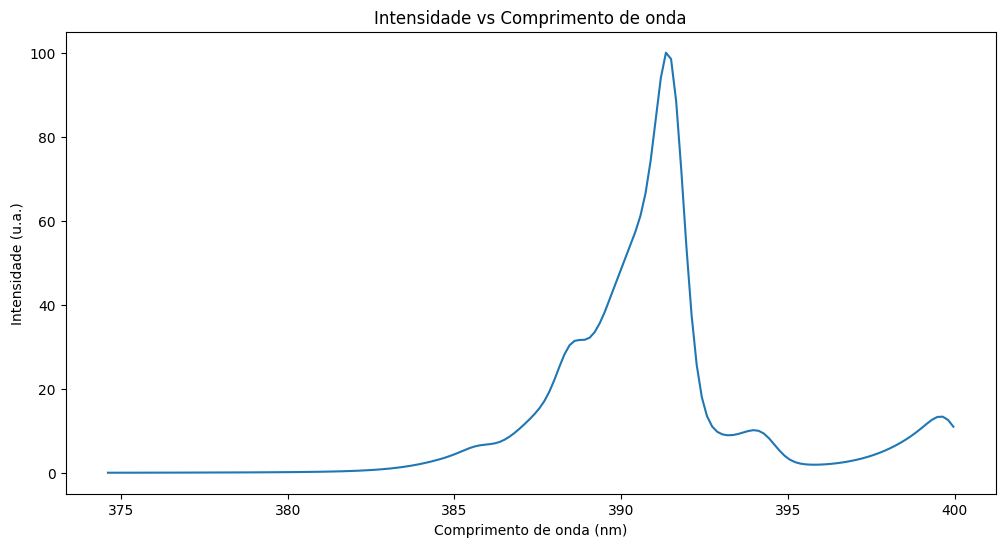

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.xlabel('Comprimento de onda (nm)')
plt.ylabel('Intensidade (u.a.)')
plt.title('Intensidade vs Comprimento de onda')

plt.show()

## Gráfico Interativo

In [37]:
px.line(x=x,y=y)

# **Comparação do Espectro Sintético com o Espectro Experimental**

## Estimativa da Razão $[N_2^+]/[N_2]$ das Concentrações

Aqui isolamos a razão presente na equação do $\alpha$ proposto por [H. Nassar](https://iopscience.iop.org/article/10.1088/0022-3727/37/14/005).

In [38]:
#Funções de Partição
QN2 = Calcular_Q(50, **Quantidades_SSP)
QN2Mais = Calcular_Q(50, **Quantidades_PSN)

#Estimativa da Razão
Razao_Estimada = Razao_das_Concentracoes(alpha, QN2, QN2Mais, k * TEMP_ELE)

## Comparação

Por fim, aqui comparamos o espectro experimental com o calculado

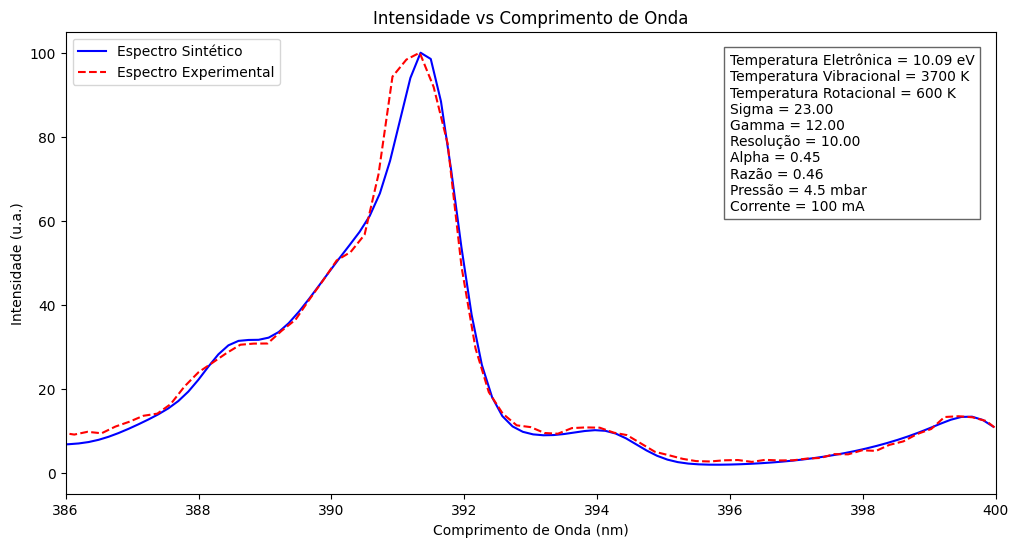

In [39]:
#Separar colunas (1ª: comprimento de onda em nm, 2ª: intensidade)
if Comp_de_Onda:
  x2 = dados_experimento.iloc[:, 0].values  #Primeira coluna (Comprimento de Onda)
else:
  x2 =  1e+7 / dados_experimento.iloc[:, 0].astype(float).values  #Primeira coluna (Numero de Onda)
y2 = dados_experimento.iloc[:, 1].values  #Segunda coluna

#Filtrar dados do Espectro Experimental para o intervalo de 385 nm a 401 nm
mask2 = (x2 >= 385) & (x2 <= 401)
x2 = (x2[mask2] + 0) #Soma para calibrar, caso o eixo x estiver descalibrado
y2 = y2[mask2]

#Normalizar Espectro Experimental para intensidade máxima = 100
y2 = (y2 / np.max(y2)) * 100

#######################################################################

#Plotagem dos dois espectros
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Espectro Sintético', color='b')
plt.plot(x2, y2, label='Espectro Experimental', color='r', linestyle='--')

#Nome dos eixos
if Comp_de_Onda:
  plt.xlabel('Comprimento de Onda (nm)')
else:
  plt.xlabel('Comprimento de Onda (nm)')
plt.ylabel('Intensidade (u.a.)')

#Ajustes para cada tipo de dado
if Comp_de_Onda:
  plt.title('Intensidade vs Comprimento de Onda')
else:
  plt.title('Intensidade vs Comprimento de Onda')

#Limita o gráfico nesta região
plt.xlim(386, 400)
plt.legend()

#Dados ajustados ou calculados
valores = (
    f"Temperatura Eletrônica = {Te_eV:.2f} eV\n"
    f"Temperatura Vibracional = {TEMP_V:.0f} K\n"
    f"Temperatura Rotacional = {TEMP_R:.0f} K\n"
    f"Sigma = {Sigma:.2f}\n"
    f"Gamma = {Gamma:.2f}\n"
    f"Resolução = {Resolucao:.2f}\n"
    f"Alpha = {alpha:.2f}\n"
    f"Razão = {Razao_Estimada:.2f}\n"
    f"Pressão = {Pressao:.1f} mbar\n"
    f"Corrente = {Corrente} mA"
)

#Legenda mostrando os dados da variável "valores"
plt.text(396, max(y2) * 0.625, valores, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.show()

# **Tabela com os Resultados Finais**

Aqui, geramos uma tabela em um arquivo *.dat* com os resultados finais do programa, como uma estimativa para os parâmetros reais do espectro experimental.

## Incertezas

Estimamos as incertezas baseadas nos cálculos que realizamos e também nos ajustes feitos, considerando a sensibilidade de cada parâmetro à variação de valores.

In [40]:
if Razao <= 12.172033905486556:
  erro_Te_eV = erro_interpolado #Erro Calculado no Inicio
else:
  erro_Te_eV = erro_ajustado #Erro Calculado no Inicio

erro_TEMP_V = 100  #A Tv é pouco sensível a pequenas variações

erro_TEMP_R = 50  #A Tr é sensível a pequenas variações

erro_Sigma = 1  #Uma unidade já altera signicativamente o perfil do espectro

erro_Gamma = 1  #Uma unidade já altera signicativamente o perfil do espectro

erro_alpha = 0.05  #Esta variação já é significativa

erro_Razao = Razao_das_Concentracoes(erro_alpha, QN2, QN2Mais, k * TEMP_ELE) #Aplicamos a função com o erro_alpha

erro_pressao = 0.1

erro_corrente = 1

## Tabela

Inclui tanto os valores quanto suas incertezas.

In [41]:
dados = [
    ("Te", f"{Te_eV:.2f} eV", f"{erro_Te_eV:.2f}"),
    ("Tv", f"{TEMP_V:.0f} K", f"{erro_TEMP_V:.0f}"),
    ("Tr", f"{TEMP_R:.0f} K", f"{erro_TEMP_R:.0f}"),
    ("Sigma", f"{Sigma:.0f}", f"{erro_Sigma:.0f}"),
    ("Gamma", f"{Gamma:.0f}", f"{erro_Gamma:.0f}"),
    ("Alpha", f"{alpha:.2f}", f"{erro_alpha:.2f}"),
    ("Ratio", f"{Razao_Estimada:.2f}", f"{erro_Razao:.2f}"),
    ("Pressao", f"{Pressao:.1f} mbar", f"{erro_pressao}"),
    ("Corrente", f"{Corrente} mA", f"{erro_corrente}")
]

#Caminho do arquivo .dat
caminho_arquivo = f"Tabela_({Pressao}mbar)_({Corrente}mA).dat"

#Escrevendo no arquivo
with open(caminho_arquivo, "w") as file:
    #Escreve o cabeçalho da tabela com formatação para o alinhamento
    file.write(f"{'Parâmetro':<25} {'Valor':<15} {'Incerteza':<12}\n")
    file.write("="*55 + "\n")  #Linha separadora

    #Escreve as linhas da tabela com o formato correto
    for parametro, valor, incerteza in dados:
        file.write(f"{parametro:<25} {valor:<15} {'+- ' + incerteza:<12}\n")

print(f"Arquivo '{caminho_arquivo}' gerado com sucesso!")

Arquivo 'Tabela_(4.5mbar)_(100mA).dat' gerado com sucesso!


# **Exemplos de Tratamento de Dados**

## Estudos para Corrente Fixa

### Temperatura Eletrônica

Catodo Oco com diâmetro de $10.9$ $mm$

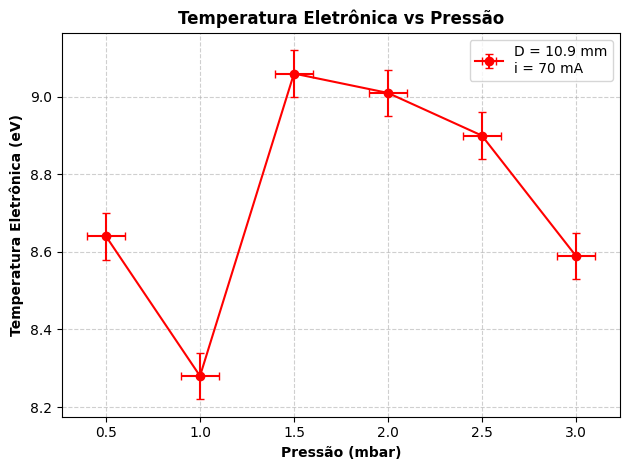

In [42]:
# Dados do eixo X
x = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# Conjunto de dados 1 (Temperatura eletrônica)
y1 = [8.64, 8.28, 9.06, 9.01, 8.90, 8.59]

# Incertezas nos dados de X e Y (exemplo: ±0.1 mbar e ±0.2 eV)
xerr = [0.1] * len(x)     # mesma incerteza para todos os pontos de x
yerr = [0.06] * len(y1)    # mesma incerteza para todos os pontos de y

# Gráfico com barras de erro
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='red', ecolor='red',
             capsize=3, label='D = 10.9 mm\ni = 70 mA')


# Configurações do gráfico
plt.title('Temperatura Eletrônica vs Pressão', fontweight='bold')
plt.xlabel('Pressão (mbar)', fontweight='bold')
plt.ylabel('Temperatura Eletrônica (eV)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Catodo Oco com diâmetro de $6.4$ $mm$

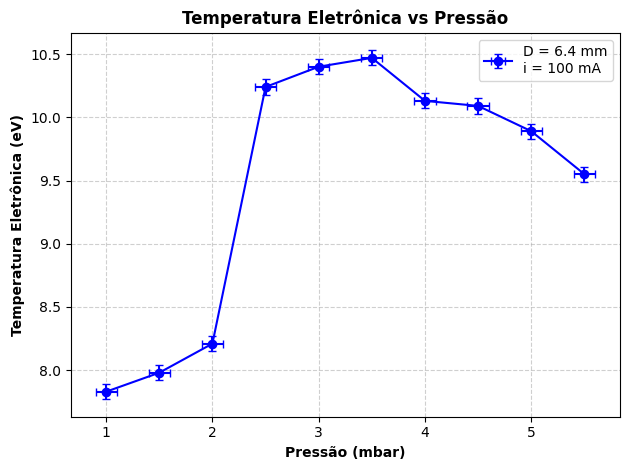

In [43]:
# Dados do eixo X
x = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]

# Conjunto de dados 1 (Temperatura eletrônica)
y1 = [7.83, 7.98, 8.21, 10.24, 10.40, 10.47, 10.13, 10.09, 9.89, 9.55]

# Incertezas nos dados de X e Y (exemplo: ±0.1 mbar e ±0.2 eV)
xerr = [0.1] * len(x)     # mesma incerteza para todos os pontos de x
yerr = [0.06] * len(y1)    # mesma incerteza para todos os pontos de y

# Gráfico com barras de erro
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='blue', ecolor='blue',
             capsize=3, label='D = 6.4 mm\ni = 100 mA')


# Configurações do gráfico
plt.title('Temperatura Eletrônica vs Pressão', fontweight='bold')
plt.xlabel('Pressão (mbar)', fontweight='bold')
plt.ylabel('Temperatura Eletrônica (eV)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Catodo Oco com diâmetro de $4.0$ $mm$

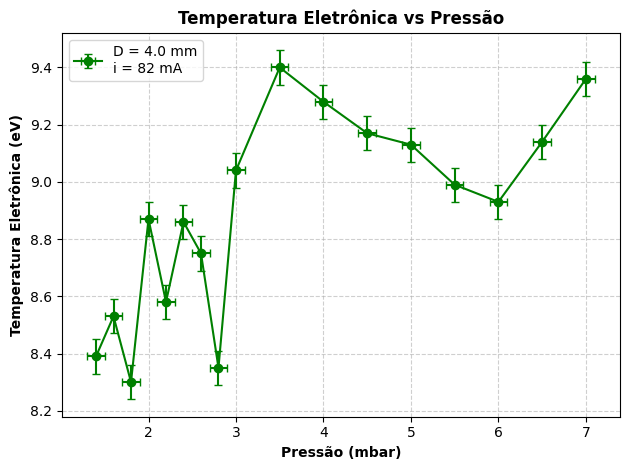

In [44]:
# Dados do eixo X
x = [1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

# Conjunto de dados 1 (Temperatura eletrônica)
y1 = [8.39, 8.53, 8.30, 8.87, 8.58, 8.86, 8.75, 8.35, 9.04, 9.40, 9.28, 9.17, 9.13, 8.99, 8.93, 9.14, 9.36]

# Incertezas nos dados de X e Y (exemplo: ±0.1 mbar e ±0.2 eV)
xerr = [0.1] * len(x)     # mesma incerteza para todos os pontos de x
yerr = [0.06] * len(y1)    # mesma incerteza para todos os pontos de y

# Gráfico com barras de erro
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='green', ecolor='green',
             capsize=3, label='D = 4.0 mm\ni = 82 mA')


# Configurações do gráfico
plt.title('Temperatura Eletrônica vs Pressão', fontweight='bold')
plt.xlabel('Pressão (mbar)', fontweight='bold')
plt.ylabel('Temperatura Eletrônica (eV)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Gráfico de Barras

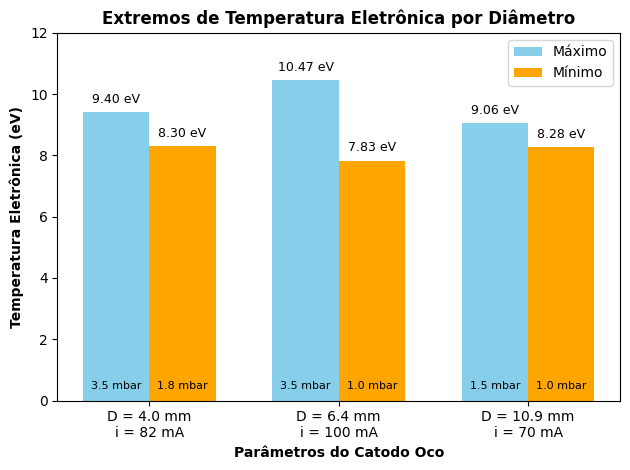

In [45]:
# Dados
correntes = [82, 100, 70]  # Correntes em mA
categorias = [
    f'D = 4.0 mm\ni = {correntes[0]} mA',
    f'D = 6.4 mm\ni = {correntes[1]} mA',
    f'D = 10.9 mm\ni = {correntes[2]} mA'
]

valores1 = [9.40, 10.47, 9.06]
valores2 = [8.30, 7.83, 8.28]

pressoes1 = [3.5, 3.5, 1.5]
pressoes2 = [1.8, 1.0, 1.0]

x = np.arange(len(categorias))
largura = 0.35

bars1 = plt.bar(x - largura/2, valores1, largura, label='Máximo', color='skyblue')
bars2 = plt.bar(x + largura/2, valores2, largura, label='Mínimo', color='orange')

for i, bar in enumerate(bars1):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f'{bar.get_height():.2f} eV', ha='center', va='bottom', fontsize=9)
    plt.text(bar.get_x() + bar.get_width()/2, 0.3,
             f'{pressoes1[i]} mbar', ha='center', va='bottom', fontsize=8)

for i, bar in enumerate(bars2):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f'{bar.get_height():.2f} eV', ha='center', va='bottom', fontsize=9)
    plt.text(bar.get_x() + bar.get_width()/2, 0.3,
             f'{pressoes2[i]} mbar', ha='center', va='bottom', fontsize=8)

plt.title('Extremos de Temperatura Eletrônica por Diâmetro', fontweight='bold')
plt.xlabel('Parâmetros do Catodo Oco', fontweight='bold')
plt.ylabel('Temperatura Eletrônica (eV)', fontweight='bold')
plt.xticks(x, categorias)
plt.ylim(0, 12)
plt.legend()
plt.tight_layout()
plt.show()

### Temperatura Vibracional

Catodo Oco com diâmetro de $10.9$ $mm$

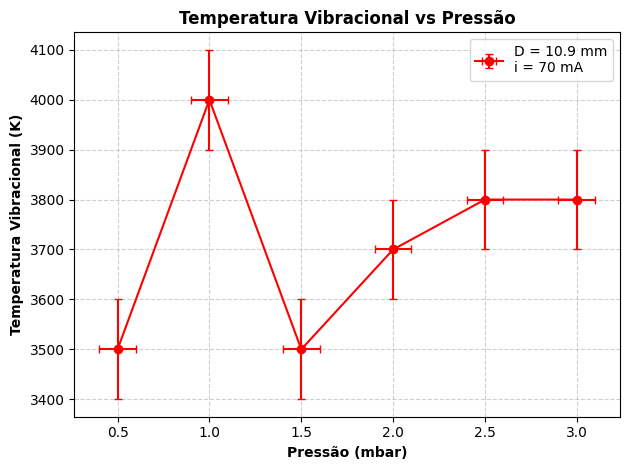

In [46]:
# Dados do eixo X
x = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# Conjunto de dados 1 (Temperatura eletrônica)
y1 = [3500, 4000, 3500, 3700, 3800, 3800]

# Incertezas nos dados de X e Y (exemplo: ±0.1 mbar e ±0.2 eV)
xerr = [0.1] * len(x)     # mesma incerteza para todos os pontos de x
yerr = [100] * len(y1)    # mesma incerteza para todos os pontos de y

# Gráfico com barras de erro
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='red', ecolor='red',
             capsize=3, label='D = 10.9 mm\ni = 70 mA')

# Configurações do gráfico
plt.title('Temperatura Vibracional vs Pressão', fontweight='bold')
plt.xlabel('Pressão (mbar)', fontweight='bold')
plt.ylabel('Temperatura Vibracional (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Catodo Oco com diâmetro de $6.4$ $mm$

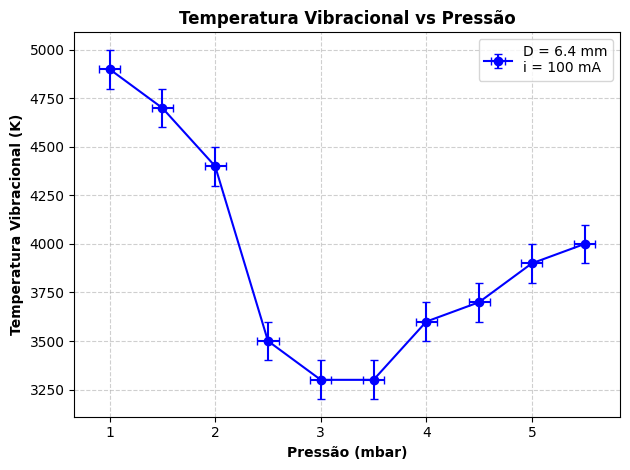

In [47]:
# Dados do eixo X
x = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]

# Conjunto de dados 1 (Temperatura eletrônica)
y1 = [4900, 4700, 4400, 3500, 3300, 3300, 3600, 3700, 3900, 4000]

# Incertezas nos dados de X e Y (exemplo: ±0.1 mbar e ±0.2 eV)
xerr = [0.1] * len(x)     # mesma incerteza para todos os pontos de x
yerr = [100] * len(y1)    # mesma incerteza para todos os pontos de y

# Gráfico com barras de erro
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='blue', ecolor='blue',
             capsize=3, label='D = 6.4 mm\ni = 100 mA')

# Configurações do gráfico
plt.title('Temperatura Vibracional vs Pressão', fontweight='bold')
plt.xlabel('Pressão (mbar)', fontweight='bold')
plt.ylabel('Temperatura Vibracional (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Catodo Oco com diâmetro de $4.0$ $mm$

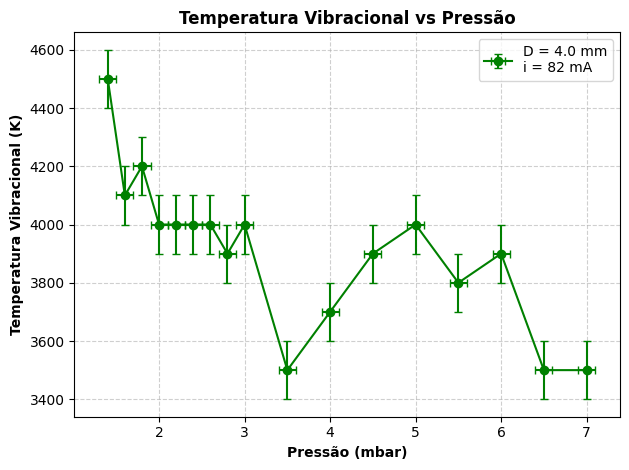

In [48]:
# Dados do eixo X
x = [1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

# Conjunto de dados 1 (Temperatura eletrônica)
y1 = [4500, 4100, 4200, 4000, 4000, 4000, 4000, 3900, 4000, 3500, 3700, 3900, 4000, 3800, 3900, 3500, 3500]

# Incertezas nos dados de X e Y (exemplo: ±0.1 mbar e ±0.2 eV)
xerr = [0.1] * len(x)     # mesma incerteza para todos os pontos de x
yerr = [100] * len(y1)    # mesma incerteza para todos os pontos de y

# Gráfico com barras de erro
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='green', ecolor='green',
             capsize=3, label='D = 4.0 mm\ni = 82 mA')

# Configurações do gráfico
plt.title('Temperatura Vibracional vs Pressão', fontweight='bold')
plt.xlabel('Pressão (mbar)', fontweight='bold')
plt.ylabel('Temperatura Vibracional (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### Temperatura Rotacional

Catodo Oco com diâmetro de $10.9$ $mm$

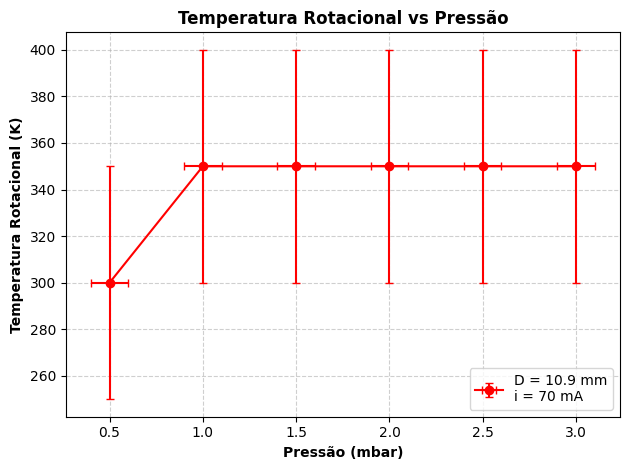

In [49]:
# Dados do eixo X
x = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# Conjunto de dados 1 (Temperatura eletrônica)
y1 = [300, 350, 350, 350, 350, 350]

# Incertezas nos dados de X e Y (exemplo: ±0.1 mbar e ±0.2 eV)
xerr = [0.1] * len(x)     # mesma incerteza para todos os pontos de x
yerr = [50] * len(y1)    # mesma incerteza para todos os pontos de y

# Gráfico com barras de erro
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='red', ecolor='red',
             capsize=3, label='D = 10.9 mm\ni = 70 mA')

# Configurações do gráfico
plt.title('Temperatura Rotacional vs Pressão', fontweight='bold')
plt.xlabel('Pressão (mbar)', fontweight='bold')
plt.ylabel('Temperatura Rotacional (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Catodo Oco com diâmetro de $6.4$ $mm$

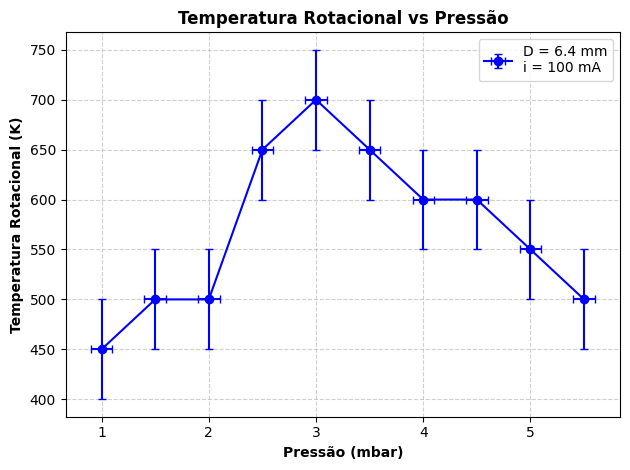

In [50]:
# Dados do eixo X
x = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]

# Conjunto de dados 1 (Temperatura eletrônica)
y1 = [450, 500, 500, 650, 700, 650, 600, 600, 550, 500]

# Incertezas nos dados de X e Y (exemplo: ±0.1 mbar e ±0.2 eV)
xerr = [0.1] * len(x)     # mesma incerteza para todos os pontos de x
yerr = [50] * len(y1)    # mesma incerteza para todos os pontos de y

# Gráfico com barras de erro
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='blue', ecolor='blue',
             capsize=3, label='D = 6.4 mm\ni = 100 mA')

# Configurações do gráfico
plt.title('Temperatura Rotacional vs Pressão', fontweight='bold')
plt.xlabel('Pressão (mbar)', fontweight='bold')
plt.ylabel('Temperatura Rotacional (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Catodo Oco com diâmetro de $4.0$ $mm$

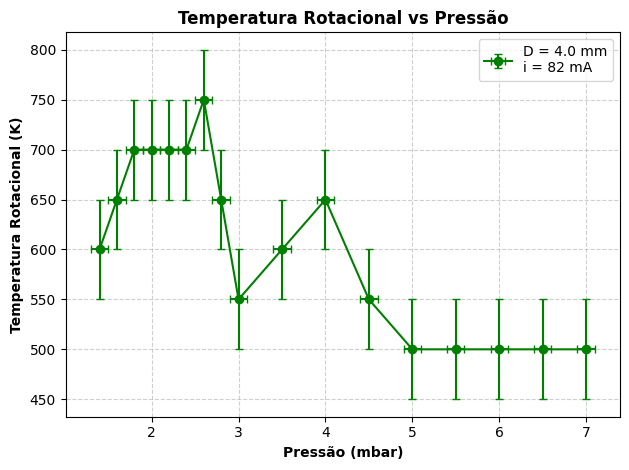

In [51]:
# Dados do eixo X
x = [1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

# Conjunto de dados 1 (Temperatura eletrônica)
y1 = [600, 650, 700, 700, 700, 700, 750, 650, 550, 600, 650, 550, 500, 500, 500, 500, 500]

# Incertezas nos dados de X e Y (exemplo: ±0.1 mbar e ±0.2 eV)
xerr = [0.1] * len(x)     # mesma incerteza para todos os pontos de x
yerr = [50] * len(y1)    # mesma incerteza para todos os pontos de y

# Gráfico com barras de erro
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='green', ecolor='green',
             capsize=3, label='D = 4.0 mm\ni = 82 mA')

# Configurações do gráfico
plt.title('Temperatura Rotacional vs Pressão', fontweight='bold')
plt.xlabel('Pressão (mbar)', fontweight='bold')
plt.ylabel('Temperatura Rotacional (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()

## Estudos para Pressão Fixa

### Temperatura Eletrônica pela Corrente

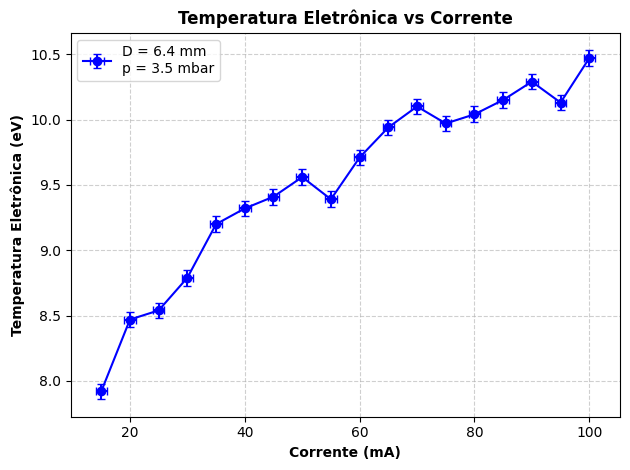

In [52]:
# Dados do eixo X
x = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# Conjunto de dados 1 (Temperatura eletrônica)
y1 = [7.92, 8.47, 8.54, 8.79, 9.20, 9.32, 9.41, 9.56, 9.39, 9.71, 9.94, 10.10, 9.97, 10.04, 10.15, 10.29, 10.13, 10.47]

# Incertezas nos dados de X e Y (exemplo: ±0.1 mbar e ±0.2 eV)
xerr = [1] * len(x)     # mesma incerteza para todos os pontos de x
yerr = [0.06] * len(y1)    # mesma incerteza para todos os pontos de y

# Gráfico com barras de erro
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='blue', ecolor='blue',
             capsize=3, label='D = 6.4 mm\np = 3.5 mbar')

# Configurações do gráfico
plt.title('Temperatura Eletrônica vs Corrente', fontweight='bold')
plt.xlabel('Corrente (mA)', fontweight='bold')
plt.ylabel('Temperatura Eletrônica (eV)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### Temperatura Vibracional pela Corrente

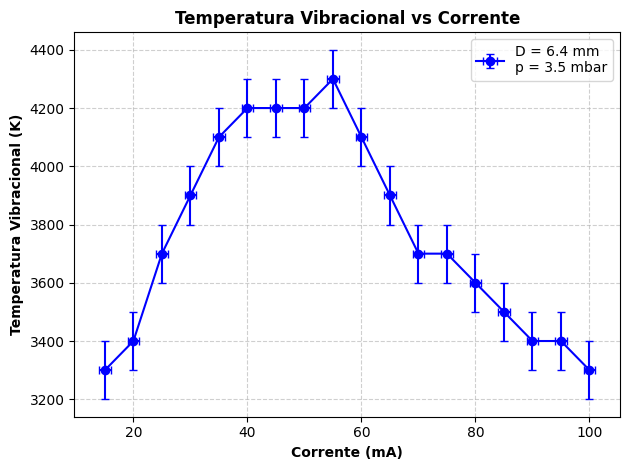

In [53]:
# Dados do eixo X
x = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# Conjunto de dados 1 (Temperatura eletrônica)
y1 = [3300, 3400, 3700, 3900, 4100, 4200, 4200, 4200, 4300, 4100, 3900, 3700, 3700, 3600, 3500, 3400, 3400, 3300]

# Incertezas nos dados de X e Y (exemplo: ±0.1 mbar e ±0.2 eV)
xerr = [1] * len(x)     # mesma incerteza para todos os pontos de x
yerr = [100] * len(y1)    # mesma incerteza para todos os pontos de y

# Gráfico com barras de erro
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='blue', ecolor='blue',
             capsize=3, label='D = 6.4 mm\np = 3.5 mbar')

# Configurações do gráfico
plt.title('Temperatura Vibracional vs Corrente', fontweight='bold')
plt.xlabel('Corrente (mA)', fontweight='bold')
plt.ylabel('Temperatura Vibracional (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### Temperatura Rotacional pela Corrente

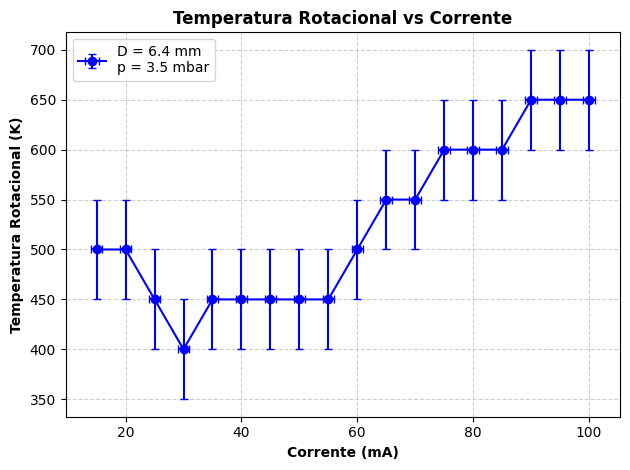

In [54]:
# Dados do eixo X
x = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# Conjunto de dados 1 (Temperatura eletrônica)
y1 = [500, 500, 450, 400, 450, 450, 450, 450, 450, 500, 550, 550, 600, 600, 600, 650, 650, 650]

# Incertezas nos dados de X e Y (exemplo: ±0.1 mbar e ±0.2 eV)
xerr = [1] * len(x)     # mesma incerteza para todos os pontos de x
yerr = [50] * len(y1)    # mesma incerteza para todos os pontos de y

# Gráfico com barras de erro
plt.errorbar(x, y1, xerr=xerr, yerr=yerr, fmt='o-', color='blue', ecolor='blue',
             capsize=3, label='D = 6.4 mm\np = 3.5 mbar')

# Configurações do gráfico
plt.title('Temperatura Rotacional vs Corrente', fontweight='bold')
plt.xlabel('Corrente (mA)', fontweight='bold')
plt.ylabel('Temperatura Rotacional (K)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()